In [7]:
import numpy as np
import matplotlib.pyplot as plt

import numba
from tqdm.notebook import tqdm

**Parameters**

In [8]:
kp = 1
konc = 1
kf = 1
t_fixed = 100
koff1 = 3.0
koff2 = 1.5

color1 = [0.528, 0.470, 0.701]
color2 = [0.560, 0.692, 0.195]

dt = 0.01
n_steps = int(t_fixed/dt)

N = 0
n_max = 300

# Start at an empty enzyme state
init_option = 0

# True: fixed time setup
# False: fixed activity setup
fixed_time = False

In [9]:
@numba.njit
def evolve(N, n_max, n_steps, konc, dt, koff, kf, kp, init_option = 0):
    
    # Probability matrix
    P_mat = np.zeros((N+2, n_max))
    
    # -------------- Initialization -------------- #
    if init_option == 0: # Empty enzyme state at t=0
        P_mat[0, 0] = 1
    
    if init_option == 1: # Steady-state enzyme states
        g = koff/kf
        x = konc/koff
        
        P_mat[0, 0] = 1/(1+x)
        
        for i in range(1, N+1):
            P_mat[i, 0] = x/(1+x) * g/(1+g)**i

        P_mat[N+1, 0] = x/(1+x) / (1+g)**N
        
        
    # -------------- Iterations -------------- #
    for it in range(n_steps):

        P_mat_next = P_mat.copy()

        for n in range(n_max):    

            P_mat_next[0, n] = P_mat[0,n] - konc * P_mat[0, n] * dt + koff * P_mat[1:, n].sum() * dt
            
            if N > 0:
                P_mat_next[1, n] = P_mat[1,n] + konc * P_mat[0, n] * dt - (kf + koff) * P_mat[1, n] * dt

                for i in range(2, N+1):
                    P_mat_next[i, n] = P_mat[i, n] + kf * P_mat[i-1, n] * dt - (kf + koff) * P_mat[i, n] * dt

                if n == 0:
                    P_mat_next[N+1, n] = P_mat[N+1, n] + kf * P_mat[N, n] * dt - koff * P_mat[N+1, n] * dt \
                                         + kp * (- P_mat[N+1, n] * dt)
                else:
                    P_mat_next[N+1, n] = P_mat[N+1, n] + kf * P_mat[N, n] * dt - koff * P_mat[N+1, n] * dt \
                                         + kp * (P_mat[N+1, n-1] - P_mat[N+1, n]) * dt
            else:
                if n == 0:
                    P_mat_next[1, n] = P_mat[1, n] + konc * P_mat[0, n] * dt - koff * P_mat[1, n] * dt \
                                       + kp * (- P_mat[1, n] * dt)
                else:
                    P_mat_next[1, n] = P_mat[1, n] + konc * P_mat[0, n] * dt - koff * P_mat[1, n] * dt \
                                       + kp * (P_mat[1, n-1] - P_mat[1, n]) * dt

        P_mat = P_mat_next.copy()
        
    return P_mat

In [10]:
@numba.njit
def give_thresh_probs(probs):
    
    thresh_probs = np.zeros(len(probs)-1)
    
    for i in range(len(probs)-1):
        thresh_probs[i] = np.sum(probs[i+1:])
        
    return thresh_probs

**ROC curves**

  0%|          | 0/5 [00:00<?, ?it/s]

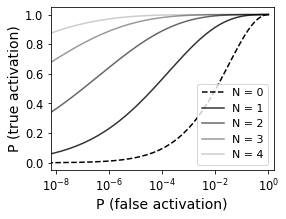

In [11]:
plt.figure(figsize = (4, 3.0))

for N in tqdm(range(0, 5)):
    
    if fixed_time:
        n_steps = int(t_fixed/dt)
    else:
        t_tuned = t_fixed * (1 + koff2/kf)**N
        n_steps = int(t_tuned/dt)
    
    P_mat_1 = evolve(N, n_max, n_steps, konc, dt, koff1, kf, kp, init_option = init_option)
    P_mat_2 = evolve(N, n_max, n_steps, konc, dt, koff2, kf, kp, init_option = init_option)
    
    P_arr_1 = np.sum(P_mat_1, axis = 0)
    P_arr_2 = np.sum(P_mat_2, axis = 0)
    
    P_false_arr = give_thresh_probs(P_arr_1)
    P_true_arr = give_thresh_probs(P_arr_2)
    
    if N == 0:
        ls = '--'
        alpha = 1
    else:
        ls = '-'
        alpha = 1 - N/5
        
    plt.plot(P_false_arr, P_true_arr, color = 'k', lw = 1.50, \
             ls = ls, alpha = alpha, label = 'N = %d'%N)
    
    
plt.legend(fontsize = 11)

plt.xscale('log')

if fixed_time:
    plt.xlim([10**-8.2, 10**0.2])
    plt.xticks([10**-8, 10**-6, 10**-4, 10**-2, 10**0])
else:
    plt.xlim([10**-8.2, 10**0.2])
    plt.xticks([10**-8, 10**-6, 10**-4, 10**-2, 10**0])

plt.xticks(fontsize = 11.5)
plt.yticks(fontsize = 11.5)

plt.xlabel('P (false activation)', fontsize = 14)
plt.ylabel('P (true activation)', fontsize = 14)

plt.show()

**Distributions of signaling molecule counts**

  0%|          | 0/4 [00:00<?, ?it/s]

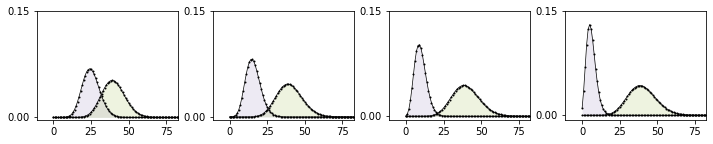

In [12]:
fig, ax = plt.subplots(1, 4, figsize = (12, 2.0))

xlims_fixed = [75, 50, 30, 15, 10]
xlims_tuned = 75

xticks_fixed = [[0, 25, 50, 75],
                [0, 25, 50], \
                [0, 10, 20, 30], \
                [0, 5, 10, 15], \
                [0, 5, 10]]
xticks_tuned = [0, 25, 50, 75]

yticks_fixed = [[0, 0.15],
                [0, 0.2],
                [0, 0.4],
                [0, 1.0],
                [0, 1.0]]


for N in tqdm(range(0, 4)):
    
    if fixed_time:
        n_steps = int(t_fixed/dt)
    else:
        t_tuned = t_fixed * (1 + koff2/kf)**N
        n_steps = int(t_tuned/dt)
    
    P_mat_1 = evolve(N, n_max, n_steps, konc, dt, koff1, kf, kp, init_option = init_option)
    P_mat_2 = evolve(N, n_max, n_steps, konc, dt, koff2, kf, kp, init_option = init_option)
    
    P_arr_1 = np.sum(P_mat_1, axis = 0)
    P_arr_2 = np.sum(P_mat_2, axis = 0)
    
    ax[N].fill_between(np.arange(n_max), P_arr_1, [0]*n_max, color = color1, alpha = 0.15, lw = 0)
    ax[N].fill_between(np.arange(n_max), P_arr_2, [0]*n_max, color = color2, alpha = 0.15, lw = 0)
    
    ax[N].plot(np.arange(n_max), P_arr_1, color = 'k', lw = 0.7)
    ax[N].plot(np.arange(n_max), P_arr_2, color = 'k', lw = 0.7)
    
    ax[N].scatter(np.arange(n_max), P_arr_1, color = 'k', s = 1)
    ax[N].scatter(np.arange(n_max), P_arr_2, color = 'k', s = 1)
    
    if fixed_time:
        ax[N].set_yticks(yticks_fixed[N])
    else:
        ax[N].set_yticks([0, 0.15])
    
    
    if fixed_time:
        x_upper = xlims_fixed[N]
        ax[N].set_xticks(xticks_fixed[N])
    else:
        x_upper = xlims_tuned
        ax[N].set_xticks(xticks_tuned)
        
        
    ax[N].set_xlim([-0.15*x_upper, 1.1*x_upper])
    
    ax[N].tick_params(labelsize = 10)
    

plt.subplots_adjust(wspace = 0.25)
plt.show()